In [ ]:
from nltk import word_tokenize
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
import re
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.pipeline import Pipeline
from scipy import sparse
from sklearn.svm import LinearSVC
import json
from sklearn.model_selection import train_test_split
import copy
import warnings

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.utils.validation import check_X_y, check_is_fitted

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, matthews_corrcoef, f1_score

In [ ]:
df = pd.read_csv('IMDB Dataset.csv')
#ali = ali[0:1000]
from sklearn.preprocessing import LabelBinarizer
lb=LabelBinarizer()

df['sentiment']=lb.fit_transform(df['sentiment'])
#df=df[0:400]
#train = ali[0:25000]
#test= ali[25000:49998]
y= df['sentiment'].values

In [ ]:
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1
...,...,...
49995,I thought this movie did a down right good job...,1
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",0
49997,I am a Catholic taught in parochial elementary...,0
49998,I'm going to have to disagree with the previou...,0


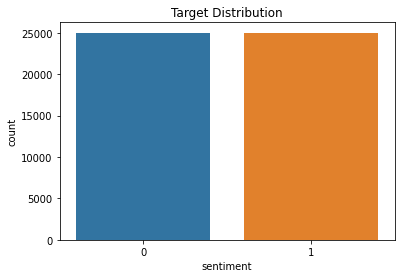

In [ ]:
sns.countplot(x="sentiment", data=df)
_ = plt.title("Target Distribution")

In [ ]:
print("NaN Distribution\n")
for col in df.columns:
    print(f"{col}: {((df[col].isna().sum()/df.shape[0])*100):.2f}")

NaN Distribution

review: 0.00
sentiment: 0.00


In [ ]:
df["review"] = df["review"].str.lower()


In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.corpus import stopwords
", ".join(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


"i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just, don, don't, should, should've, now, d, ll, m, o, re, ve, y, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn't, mustn, mus

In [ ]:
STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

df["review"] = df["review"].apply(lambda text: remove_stopwords(text))
df.head()

,review,sentiment
0,one reviewers mentioned watching 1 oz episode ...,1
1,wonderful little production. <br /><br />the f...,1
2,thought wonderful way spend time hot summer we...,1
3,basically there's family little boy (jake) thi...,0
4,"petter mattei's ""love time money"" visually stu...",1


In [ ]:
import string
PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

df["review"] = df["review"].apply(lambda text: remove_punctuation(text))

In [ ]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

df["review"] = df["review"].apply(lambda text: remove_emoji(text))

In [ ]:
def remove_urls(text):
  
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    try:
        return url_pattern.sub(r'', text)
    except:
        print(text)
    
df["review"] = df["review"].apply(lambda text: remove_urls(text))

In [ ]:
def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

df["review"] = df["review"].apply(lambda text: remove_html(text))
df['review']


0        one reviewers mentioned watching 1 oz episode ...
1        wonderful little production br br the filming ...
2        thought wonderful way spend time hot summer we...
3        basically theres family little boy jake thinks...
4        petter matteis love time money visually stunni...
                               ...                        
49995    thought movie right good job creative original...
49996    bad plot bad dialogue bad acting idiotic direc...
49997    catholic taught parochial elementary schools n...
49998    im going disagree previous comment side maltin...
49999    one expects star trek movies high art fans exp...
Name: review, Length: 50000, dtype: object

In [ ]:
from collections import Counter
cnt = Counter()
for text in df["review"].values:
    for word in text.split():
        cnt[word] += 1
        
cnt.most_common(10)

[('br', 113794),
 ('movie', 83510),
 ('film', 74453),
 ('one', 51024),
 ('like', 38989),
 ('good', 28569),
 ('the', 24954),
 ('even', 24572),
 ('would', 24024),
 ('it', 23285)]

In [ ]:
n_rare_words = 3500
RAREWORDS = set([w for (w, wc) in cnt.most_common()[:-n_rare_words-1:-1]])
def remove_rarewords(text):
    """custom function to remove the rare words"""
    return " ".join([word for word in str(text).split() if word not in RAREWORDS])
df["review"] = df["review"].apply(lambda text: remove_rarewords(text))
df.head()

,review,sentiment
0,one reviewers mentioned watching 1 oz episode ...,1
1,wonderful little production br br the filming ...,1
2,thought wonderful way spend time hot summer we...,1
3,basically theres family little boy jake thinks...,0
4,petter matteis love time money visually stunni...,1


## Get the aspect

In [ ]:
%%time
import spacy
nlp = spacy.load("en_core_web_sm")
def pos(text):
    doc = nlp(text)
    # You want list of Verb tokens 
    aspects = [token.text for token in doc if token.pos_ == "NOUN"]
    
    return aspects


df["Aspects1"] = df["review"].apply(pos)

/usr/local/lib/python3.6/dist-packages/spacy/util.py:275: UserWarning: [W031] Model 'en_core_web_sm' (2.2.0) requires spaCy v2.2 and is incompatible with the current spaCy version (2.3.2). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


CPU times: user 12min 41s, sys: 467 ms, total: 12min 41s
Wall time: 12min 41s


In [ ]:
df

,review,sentiment,Aspects1
0,one reviewers mentioned watching 1 oz episode ...,1,"[reviewers, episode, mebr, thing, brutality, s..."
1,wonderful little production br br the filming ...,1,"[production, filming, technique, oldtimebbc, f..."
2,thought wonderful way spend time hot summer we...,1,"[way, time, summer, weekend, air, theater, com..."
3,basically theres family little boy jake thinks...,0,"[family, boy, closet, parents, timebr, movie, ..."
4,petter matteis love time money visually stunni...,1,"[time, money, film, relations, movie, money, p..."
...,...,...,...
49995,thought movie right good job creative original...,1,"[thought, movie, job, expecting, lotta, fun, p..."
49996,bad plot bad dialogue bad acting idiotic direc...,0,"[plot, dialogue, directing, porn, groove, soun..."
49997,catholic taught parochial elementary schools n...,0,"[schools, nuns, priests, school, college, chur..."
49998,im going disagree previous comment side maltin...,0,"[comment, side, maltin, rate, creaks, groans, ..."


In [ ]:
STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

df["Aspects1"] = df["Aspects1"].apply(lambda text: remove_stopwords(text))
df.head()

,review,sentiment,Aspects1
0,one reviewers mentioned watching 1 oz episode ...,1,"['reviewers', 'episode', 'mebr', 'thing', 'bru..."
1,wonderful little production br br the filming ...,1,"['production', 'filming', 'technique', 'oldtim..."
2,thought wonderful way spend time hot summer we...,1,"['way', 'time', 'summer', 'weekend', 'air', 't..."
3,basically theres family little boy jake thinks...,0,"['family', 'boy', 'closet', 'parents', 'timebr..."
4,petter matteis love time money visually stunni...,1,"['time', 'money', 'film', 'relations', 'movie'..."


In [ ]:
import string
PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

df["Aspects1"] = df["Aspects1"].apply(lambda text: remove_punctuation(text))

In [ ]:
from vaderSentiment import vaderSentiment

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

sent_analyser = SentimentIntensityAnalyzer()
def sentiment(text):
    return (sent_analyser.polarity_scores(text)["compound"])

df["Aspect sentiment"] = df["Aspects1"].apply(sentiment)


In [ ]:
df

,review,sentiment,Aspects1,Aspect sentiment
0,one reviewers mentioned watching 1 oz episode ...,1,reviewers episode mebr thing brutality scenes ...,-0.9912
1,wonderful little production br br the filming ...,1,production filming technique oldtimebbc fashio...,0.1531
2,thought wonderful way spend time hot summer we...,1,way time summer weekend air theater comedy plo...,0.5267
3,basically theres family little boy jake thinks...,0,family boy closet parents timebr movie soap op...,0.0000
4,petter matteis love time money visually stunni...,1,time money film relations movie money power su...,0.5719
...,...,...,...,...
49995,thought movie right good job creative original...,1,thought movie job expecting lotta fun pay mone...,0.7906
49996,bad plot bad dialogue bad acting idiotic direc...,0,plot dialogue directing porn groove soundtrack...,0.8020
49997,catholic taught parochial elementary schools n...,0,schools nuns priests school college churchs ey...,-0.8885
49998,im going disagree previous comment side maltin...,0,comment side maltin rate creaks groans theme t...,-0.8271


In [ ]:
df

,review,sentiment,Aspects1,Aspect sentiment
0,one reviewers mentioned watching 1 oz episode ...,1,reviewers episode mebr thing brutality scenes ...,-0.9912
1,wonderful little production br br the filming ...,1,production filming technique oldtimebbc fashio...,0.1531
2,thought wonderful way spend time hot summer we...,1,way time summer weekend air theater comedy plo...,0.5267
3,basically theres family little boy jake thinks...,0,family boy closet parents timebr movie soap op...,0.0000
4,petter matteis love time money visually stunni...,1,time money film relations movie money power su...,0.5719
...,...,...,...,...
49995,thought movie right good job creative original...,1,thought movie job expecting lotta fun pay mone...,0.7906
49996,bad plot bad dialogue bad acting idiotic direc...,0,plot dialogue directing porn groove soundtrack...,0.8020
49997,catholic taught parochial elementary schools n...,0,schools nuns priests school college churchs ey...,-0.8885
49998,im going disagree previous comment side maltin...,0,comment side maltin rate creaks groans theme t...,-0.8271


## LDA model

In [ ]:
#from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')

#tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [ ]:
# df = df.rename(columns={'Review_text': 'text'})
# df = df.rename(columns={'Rating': 'review_stars'})
# from sklearn.preprocessing import LabelBinarizer
# lb=LabelBinarizer()

# df['sentiment']=lb.fit_transform(df['sentiment'])
# y= df['sentiment'].values

In [ ]:
from vaderSentiment import vaderSentiment

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

sent_analyser = SentimentIntensityAnalyzer()
def sentiment(text):
    return (sent_analyser.polarity_scores(text)["compound"])

df["Polarity based on aspect"] = df["Aspects1"].apply(sentiment)
df["Polarity based on review "] = df["review"].apply(sentiment)


In [ ]:
df['sentiment'].value_counts()

1    25000
0    25000
Name: sentiment, dtype: int64

In [ ]:
%%time
#tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
#tokenizer1 = XLNetTokenizer.from_pretrained('xlnet-large-cased')
from nltk import word_tokenize 
data_words = [word_tokenize(sent) for sent in df['Aspects1']]
print ("Tokenize the first sentence:")
print (data_words[0])

Tokenize the first sentence:
['reviewers', 'episode', 'mebr', 'thing', 'brutality', 'scenes', 'violence', 'word', 'show', 'pulls', 'punches', 'drugs', 'sex', 'violence', 'use', 'wordbr', 'nickname', 'security', 'state', 'penitentary', 'section', 'prison', 'cells', 'glass', 'fronts', 'inwards', 'privacy', 'agenda', 'city', 'home', 'manyaryans', 'gangstas', 'moreso', 'death', 'stares', 'dealings', 'agreements', 'appeal', 'show', 'fact', 'shows', 'pictures', 'audiences', 'charm', 'forget', 'mess', 'episode', 'taste', 'levels', 'violence', 'violence', 'injustice', 'guards', 'nickel', 'inmates', 'order', 'class', 'inmates', 'prison', 'bitches', 'street', 'prison', 'experience', 'viewingthats', 'touch', 'side']
CPU times: user 8.35 s, sys: 0 ns, total: 8.35 s
Wall time: 8.35 s


In [ ]:
import gensim
from gensim import models

bigram = gensim.models.Phrases(data_words, min_count=3, threshold=120) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words],min_count=3, threshold=20)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['reviewers', 'episode', 'mebr', 'thing', 'brutality', 'scenes', 'violence', 'word', 'show', 'pulls_punches', 'drugs', 'sex', 'violence', 'use', 'wordbr', 'nickname', 'security', 'state', 'penitentary', 'section', 'prison_cells', 'glass', 'fronts', 'inwards', 'privacy', 'agenda', 'city', 'home', 'manyaryans', 'gangstas', 'moreso', 'death', 'stares', 'dealings', 'agreements', 'appeal', 'show', 'fact', 'shows', 'pictures', 'audiences', 'charm', 'forget', 'mess', 'episode', 'taste', 'levels', 'violence', 'violence', 'injustice', 'guards', 'nickel', 'inmates', 'order', 'class', 'inmates_prison', 'bitches', 'street', 'prison', 'experience', 'viewingthats', 'touch', 'side']


In [ ]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [ ]:
%%time

# Remove Stop Words
#data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
#data_words_trigrams = make_trigrams(data_words)
data_lemmatized = make_trigrams(data_words)


# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
import spacy
#nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
#data_lemmatized = lemmatization(data_words_trigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:3])

[['reviewers', 'episode', 'mebr', 'thing', 'brutality', 'scenes', 'violence', 'word', 'show', 'pulls_punches', 'drugs', 'sex', 'violence', 'use', 'wordbr', 'nickname', 'security', 'state', 'penitentary', 'section', 'prison_cells', 'glass', 'fronts', 'inwards', 'privacy', 'agenda', 'city', 'home', 'manyaryans', 'gangstas', 'moreso', 'death', 'stares', 'dealings', 'agreements', 'appeal', 'show', 'fact', 'shows', 'pictures', 'audiences', 'charm', 'forget', 'mess', 'episode', 'taste', 'levels', 'violence', 'violence', 'injustice', 'guards', 'nickel', 'inmates', 'order', 'class', 'inmates_prison', 'bitches', 'street', 'prison', 'experience', 'viewingthats', 'touch', 'side'], ['production', 'filming_technique', 'oldtimebbc', 'fashion', 'sense', 'realism', 'piece', 'actors', 'voices', 'references', 'entries', 'piece', 'production', 'masters', 'life', 'realism', 'things', 'fantasy', 'guard', 'dream', 'techniques', 'disappears', 'plays', 'knowledge', 'senses', 'scenes', 'sets', 'halliwells', 'm

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(data_lemmatized, df["sentiment"],
                                                      test_size=0.3, random_state=42,
                                                      stratify=df["sentiment"])

In [ ]:
# Create Dictionary
from gensim import corpora

id2word = corpora.Dictionary(X_train)

# Create Corpus
texts = X_train

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:6])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1)], [(14, 1), (15, 1), (16, 1), (17, 3), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1)], [(31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 3), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 2), (48, 1)], [(12, 1), (40, 2), (41, 1), (49, 1), (50, 1), (51, 2), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1)], [(47, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 2), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1), (85, 1), (86, 1), (87, 1), (88, 1), (89, 1), (90, 1)], [(29, 1), (40, 1), (79, 1), (91, 1), (92, 1), (93, 2), (94, 1), (95, 1), (96, 1), (97, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (103,

In [ ]:
## test

# Create Dictionary
id2word1 = corpora.Dictionary(X_valid)

# Create Corpus
texts1 = X_valid

# Term Document Frequency
corpus1 = [id2word.doc2bow(text) for text in texts1]

# View
print(corpus1[0])

[(40, 2), (81, 1), (97, 1), (192, 1), (497, 1), (565, 1), (694, 2), (1202, 1), (2119, 1), (7492, 1), (9150, 1), (9295, 1)]


In [ ]:
%%time
# Build LDA model
import numpy as np
from numpy.random import randint
lda_train4 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=42,
                                           update_every=5,
                                           chunksize=20,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

CPU times: user 4min 53s, sys: 0 ns, total: 4min 53s
Wall time: 4min 53s


In [ ]:
# from gensim.models import CoherenceModel

# coherence_model_lda = CoherenceModel(model=lda_train4, texts=texts1, dictionary=id2word1, coherence='c_v')
# #coherence_model_lda1 = CoherenceModel(model=lda_train4, texts=X_valid, dictionary=id2word1, coherence='c_npmi')

# coherence_lda = coherence_model_lda.get_coherence()
# print("THe coherence score is :", coherence_lda)

In [ ]:
lda_noun=lda_train4.print_topics(6,num_words=20)
print(len(lda_noun))
print(lda_noun)


6
[(3, '0.010*"par" + 0.007*"poison" + 0.006*"relate" + 0.004*"swallow" + 0.000*"bradburys" + 0.000*"maud" + 0.000*"emasculation" + 0.000*"straightheads" + 0.000*"heyheytwister" + 0.000*"tornadoes" + 0.000*"twister" + 0.000*"wards" + 0.000*"formulas" + 0.000*"carruthers" + 0.000*"penury" + 0.000*"shazam" + 0.000*"laws_gravity" + 0.000*"qualms" + 0.000*"solace" + 0.000*"curves"'), (6, '0.044*"gags" + 0.023*"basement" + 0.019*"gag" + 0.015*"spy" + 0.012*"bottle" + 0.011*"hitchcock" + 0.011*"button" + 0.009*"end_credits" + 0.009*"bath" + 0.004*"antihero" + 0.003*"assistants" + 0.000*"beep" + 0.000*"title_cards" + 0.000*"hitmen" + 0.000*"road_runner" + 0.000*"skeletor" + 0.000*"tromeo" + 0.000*"trust_fund" + 0.000*"reactor" + 0.000*"quickfire"'), (8, '0.054*"week" + 0.051*"impression" + 0.042*"move" + 0.033*"months" + 0.027*"sequels" + 0.022*"surface" + 0.020*"vampire" + 0.019*"depiction" + 0.019*"expressions" + 0.014*"eighties" + 0.013*"alltime" + 0.012*"conversations" + 0.009*"integrity"



```
# This is formatted as code
```

## extract only the aspects word from the tuples

In [ ]:
lda_output=[]
for i in range(len(lda_noun)):
    print('\n')
    print(lda_noun[i][1])
    print(i)
    for j in range(len(lda_noun[i][1].split('"'))):
        if(j % 2 != 0):
            print(i,j)
            print(lda_noun[i][1].split('"')[j])
            lda_output.append(lda_noun[i][1].split('"')[j])



0.010*"par" + 0.007*"poison" + 0.006*"relate" + 0.004*"swallow" + 0.000*"bradburys" + 0.000*"maud" + 0.000*"emasculation" + 0.000*"straightheads" + 0.000*"heyheytwister" + 0.000*"tornadoes" + 0.000*"twister" + 0.000*"wards" + 0.000*"formulas" + 0.000*"carruthers" + 0.000*"penury" + 0.000*"shazam" + 0.000*"laws_gravity" + 0.000*"qualms" + 0.000*"solace" + 0.000*"curves"
0
0 1
par
0 3
poison
0 5
relate
0 7
swallow
0 9
bradburys
0 11
maud
0 13
emasculation
0 15
straightheads
0 17
heyheytwister
0 19
tornadoes
0 21
twister
0 23
wards
0 25
formulas
0 27
carruthers
0 29
penury
0 31
shazam
0 33
laws_gravity
0 35
qualms
0 37
solace
0 39
curves


0.044*"gags" + 0.023*"basement" + 0.019*"gag" + 0.015*"spy" + 0.012*"bottle" + 0.011*"hitchcock" + 0.011*"button" + 0.009*"end_credits" + 0.009*"bath" + 0.004*"antihero" + 0.003*"assistants" + 0.000*"beep" + 0.000*"title_cards" + 0.000*"hitmen" + 0.000*"road_runner" + 0.000*"skeletor" + 0.000*"tromeo" + 0.000*"trust_fund" + 0.000*"reactor" + 0.000*"qu

In [ ]:
print(len(lda_output))
print(type(lda_output))
print(lda_output)

120
<class 'list'>
['par', 'poison', 'relate', 'swallow', 'bradburys', 'maud', 'emasculation', 'straightheads', 'heyheytwister', 'tornadoes', 'twister', 'wards', 'formulas', 'carruthers', 'penury', 'shazam', 'laws_gravity', 'qualms', 'solace', 'curves', 'gags', 'basement', 'gag', 'spy', 'bottle', 'hitchcock', 'button', 'end_credits', 'bath', 'antihero', 'assistants', 'beep', 'title_cards', 'hitmen', 'road_runner', 'skeletor', 'tromeo', 'trust_fund', 'reactor', 'quickfire', 'week', 'impression', 'move', 'months', 'sequels', 'surface', 'vampire', 'depiction', 'expressions', 'eighties', 'alltime', 'conversations', 'integrity', 'worker', 'intent', 'natives', 'chorus', 'cameo', 'icon', 'winters', 'episode', 'war', 'song', 'fight', 'bed', 'track', 'cartoon', 'scientist', 'horse', 'dogs', 'tragedy', 'top', 'floor', 'dreams', 'fathers', 'villains', 'mark', 'theatre', 'shoot', 'training', 'movie', 'movies', 'scenes', 'scene', 'action', 'horror', 'plot', 'watch', 'girl', 'job', 'effects', 'guy',

In [ ]:
#df.dropna(axis='columns')

In [ ]:
aspect_list = pd.DataFrame(lda_output) 
aspect_list

,0
0,par
1,poison
2,relate
3,swallow
4,bradburys
...,...
115,fact
116,show
117,love
118,part


In [ ]:
aspect_list = aspect_list.rename(columns={0: "aspect_list"})

In [ ]:
aspect_list

,aspect_list
0,par
1,poison
2,relate
3,swallow
4,bradburys
...,...
115,fact
116,show
117,love
118,part


## convert the dataset to list

In [ ]:
review_to_list = df["review"].tolist() 
review_to_list

['one reviewers mentioned watching 1 oz episode hooked right exactly happened mebr br the first thing struck oz brutality unflinching scenes violence set right word go trust me show faint hearted timid show pulls punches regards drugs sex violence hardcore classic use wordbr br it called oz nickname given oswald maximum security state penitentary focuses mainly emerald city experimental section prison cells glass fronts face inwards privacy high agenda em city home manyaryans muslims gangstas latinos christians italians irish moreso scuffles death stares dodgy dealings shady agreements never far awaybr br i would say main appeal show due fact goes shows dare forget pretty pictures painted mainstream audiences forget charm forget romanceoz mess around first episode ever saw struck nasty surreal say ready it watched more developed taste oz got accustomed high levels graphic violence violence injustice crooked guards wholl sold nickel inmates wholl kill order get away it well mannered mid

In [ ]:
dataset_review_words = [word for phrase in review_to_list for word in phrase.split(" ")]
len(dataset_review_words)
print(type(dataset_review_words))

<class 'list'>


## sepearate the positive and  negative reviews and convert them to list

In [ ]:
num_reviews = df["review"].size
 
positive_reviews = []
negative_reviews = []
 
#Positive reviews have a sentiment of 1, negative a sentiment of 0
 
 
for i in range( 0, num_reviews ):
    if df["sentiment"][i] == 1:
         positive_reviews.append(df["review"][i])
    else:
        if df["sentiment"][i] == 0:
         negative_reviews.append(df["review"][i])

In [ ]:
positive_reviews_words = [word for phrase in positive_reviews for word in phrase.split(" ")]
negative_reviews_words = [word for phrase in negative_reviews for word in phrase.split(" ")]

print(len(positive_reviews_words))
print(len(negative_reviews_words))
print(len(dataset_review_words))


3190095
3126801
6316896


## find the number of the frequent words of the aspect in the positive and negative review

In [ ]:
def countX(dataset_review_words, x): 
    count = 0
    for ele in dataset_review_words: 
        if (ele == x): 
            count = count + 1
    return count 
  
# Driver Code 
x = 'relate'
print('{} has occurred {} times'.format(x, countX(dataset_review_words, x))) 

relate has occurred 507 times


In [ ]:
df1 = pd.DataFrame()


## In positive

In [ ]:
count = 0
aspect_frequent_positive = []
aspect_positive = []
for i in range (len(lda_output)): 
    for ele in ((positive_reviews_words)): 
         if (ele == lda_output[i]): 
            count = count + 1
    aspect_frequent_positive.append(count)
    aspect_positive.append(lda_output[i])

    
        
    

## In negative

In [ ]:
count = 0
aspect_frequent_negative = []
aspect_negative = []
for i in range (len(lda_output)): 
    for ele in ((negative_reviews_words)): 
         if (ele == lda_output[i]): 
            count = count + 1
    aspect_frequent_negative.append(count)

    

In [ ]:
df1 = pd.DataFrame(lda_output)


In [ ]:
df1['aspect'] = pd.DataFrame(lda_output)
df1['aspect_frequent_positive'] = pd.DataFrame(aspect_frequent_positive)
df1['aspect_frequent_negative'] = pd.DataFrame(aspect_frequent_negative) 
df1

,0,aspect,aspect_frequent_positive,aspect_frequent_negative
0,par,par,128,176
1,poison,poison,190,243
2,relate,relate,547,393
3,swallow,swallow,585,453
4,bradburys,bradburys,587,467
...,...,...,...,...
115,fact,fact,251570,259544
116,show,show,257985,265158
117,love,love,266401,269312
118,part,part,270313,273036


## give sentiment to the aspect based on the frequnt majorety

In [ ]:
def f(df1):
    if df1['aspect_frequent_positive'] >= df1['aspect_frequent_negative']:
        val = 1
    else:
        val = 0
    return val
df1['aspect_polairty'] = df1.apply(f, axis=1)

In [ ]:
df1['all_frequent_aspect'] = df1['aspect_frequent_positive'] + df1['aspect_frequent_negative']

## find out the probability of aspect 

In [ ]:
def f(df1):
    if df1['aspect_frequent_positive'] >= df1['aspect_frequent_negative']:
        val = df1['aspect_frequent_positive']/ df1['all_frequent_aspect']
    else:
        val = df1['aspect_frequent_negative']/ df1['all_frequent_aspect']
    return val
df1['probability of aspect'] = df1.apply(f, axis=1)

In [ ]:
print('mean is: ',df1['probability of aspect'].mean())
print('max is:',df1['probability of aspect'].max())
print('min is:',df1['probability of aspect'].min())


mean is:  0.5367022951987944
max is: 0.5819148936170213
min is: 0.502079535664082


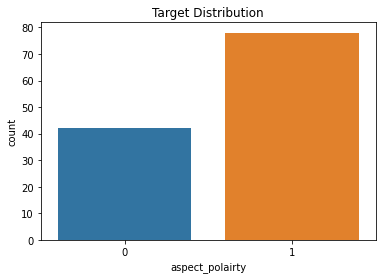

In [ ]:
sns.countplot(x="aspect_polairty", data=df1)
_ = plt.title("Target Distribution")

## descending order of the aspect probability/


In [ ]:
df1.sort_values(by=['probability of aspect'], inplace=True,ascending=False)
df1

,0,aspect,aspect_frequent_positive,aspect_frequent_negative,aspect_polairty,all_frequent_aspect,probability of aspect
2,relate,relate,547,393,1,940,0.581915
0,par,par,128,176,0,304,0.578947
62,song,song,12202,9187,1,21389,0.570480
61,war,war,11035,8411,1,19446,0.567469
5,maud,maud,606,468,1,1074,0.564246
...,...,...,...,...,...,...,...
112,things,things,240049,244803,0,484852,0.504903
46,vampire,vampire,4771,4679,1,9450,0.504868
117,love,love,266401,269312,0,535713,0.502717
118,part,part,270313,273036,0,543349,0.502506


In [ ]:
##Is the aspect and topic are same?


## Classification

In [ ]:
from nltk.stem.porter import *
stemmer = PorterStemmer()
import nltk
nltk.download('punkt')
def stemming_tokenizer(text):
    #lemmatizer = WordNetLemmatizer() 
    tokenizer1 = XLNetTokenizer.from_pretrained('xlnet-large-cased')
    from nltk.tokenize import word_tokenize 
    all_stopwords = stopwords.words('english')

    stemmer = PorterStemmer()
    return [stemmer.stem(w) for w in tokenizer1.tokenize(text)]



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
class NBSVMClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, C=1.0, max_iter=100, dual=False, n_jobs=1):
        self.C = C
        self.dual = dual
        self.n_jobs = n_jobs
        self.max_iter = max_iter

    def predict(self, x):
        check_is_fitted(self, ['_r', '_clf'])
        return self._clf.predict(x.multiply(self._r))

    def fit(self, x, y):
        y = y.values
        x, y = check_X_y(x, y, accept_sparse=True)

        def pr(x, y_i, y):
            p = x[y==y_i].sum(0)
            return (p+1) / ((y==y_i).sum()+1)

        self._r = sparse.csr_matrix(np.log(pr(x,1,y) / pr(x,0,y)))
        x_nb = x.multiply(self._r)
        self._clf = LogisticRegression(C=self.C, dual=self.dual, 
                                       max_iter=self.max_iter, 
                                       n_jobs=self.n_jobs).fit(x_nb, y)
        return self


In [ ]:
SEED = 42
NUM_SPLITS = 10
NUM_TRIALS = 1

In [ ]:
# X_train, X_valid, y_train, y_valid = train_test_split(df["review"], df["sentiment"],
#                                                       test_size=0.3, random_state=SEED,
#                                                       stratify=df["sentiment"])

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(df["Aspects1"], df["sentiment"],
                                                      test_size=0.3, random_state=SEED,
                                                      stratify=df["sentiment"])

In [ ]:
X_train


27509    thriller rent director screenwriter feature ov...
34629    columbos columbo villains wife culp business s...
15277    movie war aunt movie wedding horse script cost...
1062     movie madebr jokes movies corny castbr story c...
38939    90s scope production breathtaking characters h...
                               ...                        
39654    show hoopla show promises quality itbr letdown...
22917    time shades directors staff movie knowing acto...
47481    danger watch production dialog plot line perfo...
35597    movie piece story line odes water actor movie ...
27491    movie impression school home night respect rol...
Name: Aspects1, Length: 35000, dtype: object

In [ ]:
import nltk
nltk.download('stopwords')
vec = TfidfVectorizer(ngram_range=(1,2), min_df=3, max_df=0.9,  
                      strip_accents='unicode', use_idf=1,tokenizer= stemming_tokenizer,
                      smooth_idf=1, sublinear_tf=1)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
import optuna
from transformers import *

def objective(trial):
    C = trial.suggest_float(name="C", low=1e-3, high=1e3, log=True)
    max_iter = trial.suggest_discrete_uniform(name="max_iter", low=50, high=500, q=50)
    nbsvm = NBSVMClassifier(C=C, max_iter=max_iter)
    
    train_term_doc = vec.fit_transform(X_train)
    valid_term_doc = vec.transform(X_valid)
    nbsvm.fit(train_term_doc, y_train)
    
    preds = nbsvm.predict(valid_term_doc)
    preds[preds>=0.5] = 1
    preds[preds<0.5] = 0
    
    acc = accuracy_score(y_valid, preds)
    return acc
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=NUM_TRIALS, show_progress_bar=True)

[I 2020-10-15 21:47:28,240] A new study created in memory with name: no-name-f1ccda87-a6e2-4ed7-8757-43ab7a491229
/usr/local/lib/python3.6/dist-packages/optuna/progress_bar.py:46: ExperimentalWarning:

Progress bar is experimental (supported from v1.2.0). The interface can change in the future.



In [ ]:

print(f"Best Value: {study.best_trial.value}")
print(f"Best Params: {study.best_params}")

In [ ]:
kwargs = study.best_params

In [ ]:
def print_metrics(y_true, y_pred):
    print(f"Accuracy: {accuracy_score(y_true, y_pred)}")
    print(f"MCC: {matthews_corrcoef(y_true, y_pred)}")
    print(f"F1: {f1_score(y_true, y_pred)}\n")

In [ ]:
train_term_doc = vec.fit_transform(X_train)
valid_term_doc = vec.transform(X_valid)
nbsvm = NBSVMClassifier(**kwargs)
nbsvm.fit(train_term_doc, y_train)
    
valid_preds = nbsvm.predict(valid_term_doc)
print_metrics(y_valid, valid_preds)

Accuracy: 0.9213333333333333
MCC: 0.8427099343781452
F1: 0.9217299018307242



In [ ]:
####BERT 

In [ ]:
import nltk
import keras
from nltk.corpus import RegexpTokenizer as regextoken
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import gensim
from gensim.models.keyedvectors import KeyedVectors
from keras.models import Sequential, Model
from keras.layers import Dense, Embedding, LSTM, Dropout
from keras.regularizers import l1, l2
from sklearn.metrics import classification_report
from sklearn import preprocessing

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
import tensorflow as tf
import tensorflow_estimator
import tensorflow_hub as hub
from datetime import datetime
import bert
from bert import optimization
from bert import tokenization
import warnings
warnings.filterwarnings("ignore")


In [ ]:

pip install tensorflow==1.15


You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from bert import run_classifier

ModuleNotFoundError: No module named 'tensorflow.contrib'

In [ ]:
data = df 
data

,review,sentiment
0,one reviewers mentioned watching 1 oz episode ...,1
1,wonderful little production br br the filming ...,1
2,thought wonderful way spend time hot summer we...,1
3,basically theres family little boy jake thinks...,0
4,petter matteis love time money visually stunni...,1
...,...,...
49995,thought movie right good job creative original...,1
49996,bad plot bad dialogue bad acting idiotic direc...,0
49997,catholic taught parochial elementary schools n...,0
49998,im going disagree previous comment side maltin...,0


In [ ]:
# Preparing training and test data for BERT
label_encoder = preprocessing.LabelEncoder()
data['sentiment'] = label_encoder.fit_transform(data['sentiment'])
trainingSet, testSet = train_test_split(data, test_size=0.2)

In [ ]:
# Defining input and label columns
DATA_COLUMN = 'review'
LABEL_COLUMN = 'sentiment'
# label_list is the list of labels, i.e. True, False or 0, 1 or 'dog', 'cat'
label_list = [0, 1]

In [ ]:
# Data Preprocessing for BERT
# Use the InputExample class from BERT's run_classifier code to create examples from the data
train_InputExamples = trainingSet.apply(lambda x: bert.run_classifier.InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this example
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

test_InputExamples = testSet.apply(lambda x: bert.run_classifier.InputExample(guid=None, 
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

AttributeError: module 'bert' has no attribute 'run_classifier'